# B20-RO Lev Kozlov

View in [github](https://github.com/lvjonok/s23-sensors)

In [1]:
!pip3 install seaborn matplotlib numpy scipy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

Defaulting to user installation because normal site-packages is not writeable


# Task 1

- Apply Kalman filter on noisy 1D data
- Demonstrate 1D linear Kalman filter estimation on data
- Create simplified recrusive filter and compare its results with 1D Kalman filter
- Prove filter convergence with different values for initialization

In [2]:
# describe parameters of error of the model and error of the sensor and their variance
sigma_model = 1
sigma_sensor = 10

## Test model

## Newton's law of cooling

$$\frac{dT}{dt} = -k(T - T_{amb})$$

where $T$ is temperature of the object, $T_{amb}$ is ambient temperature, $k$ is the cooling coefficient.

$$ T_{k+1} = T_k + \frac{dT}{dt} \Delta t = T_k - k(T_k - T_{amb}) \Delta t $$

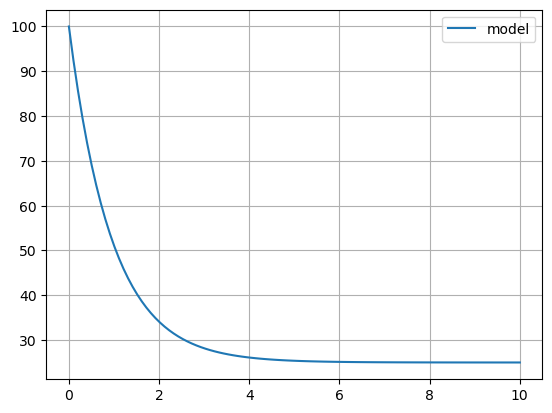

In [3]:
t = np.linspace(0, 10, 100)

k = 1
T_amb = 25

T0 = 100
temperatures = np.array([T0])

for i in range(1, len(t)):
    dt = t[i] - t[i-1]
    T_k = temperatures[i-1] + k * (T_amb - temperatures[i-1]) * dt
    temperatures = np.append(temperatures, T_k)

sns.lineplot(x=t, y=temperatures, label='model')
plt.grid()

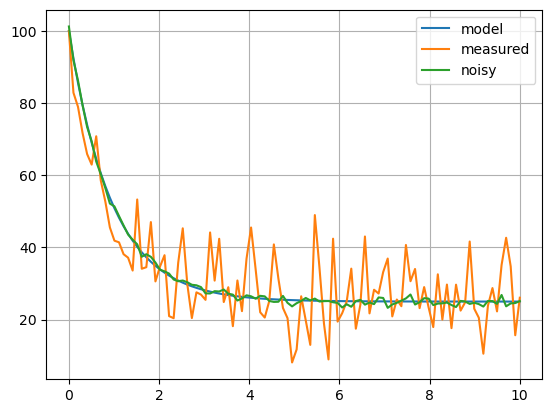

In [4]:
temp_noisy = temperatures + np.random.normal(0, sigma_model, len(t))
measured = temp_noisy + np.random.normal(0, sigma_sensor, len(t))

sns.lineplot(x=t, y=temperatures, label='model')
sns.lineplot(x=t, y=measured, label='measured')
sns.lineplot(x=t, y=temp_noisy, label='noisy')
plt.grid()

In [5]:
def kalman_filter_1d(measured, sigma_model, sigma_sensor, x0_opt=None, e0_opt=None) -> np.ndarray:
    """
    1D kalman filter, returns the optimal values and kalman gains
    """
    var_sensor = sigma_sensor ** 2
    var_model = sigma_model ** 2

    # kalman filter
    if x0_opt is None:
        temperatures_opt = [measured[0]]
    else:
        temperatures_opt = [x0_opt]

    if e0_opt is None:
        e_opt = [sigma_sensor]
    else:
        e_opt = [e0_opt]

    kalman_gains = [sigma_sensor ** 2 / var_sensor]

    dt = t[1] - t[0]

    for i in range(1, len(t)):
        e_opt_next = np.sqrt(var_sensor * (e_opt[-1] **2 + var_model) / (var_sensor + e_opt[-1] **2 + var_model))
        e_opt.append(e_opt_next)

        kalman_gain = e_opt_next ** 2 / var_sensor
        kalman_gains.append(kalman_gain)

        temp_next = temperatures_opt[-1] + k * (T_amb - temperatures_opt[-1]) * dt

        temp_opt_next = temp_next * (1 - kalman_gain) + (measured[i]) * kalman_gain
        temperatures_opt.append(temp_opt_next)
    
    return np.array(temperatures_opt), np.array(kalman_gains)

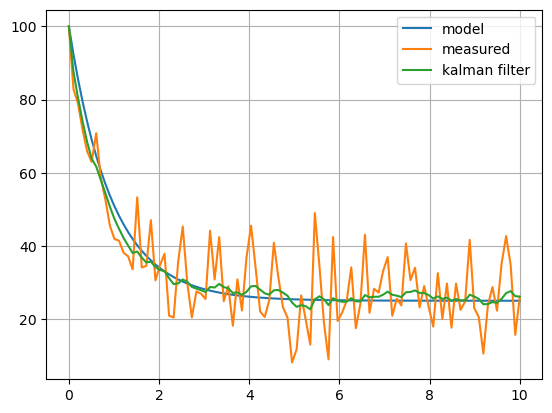

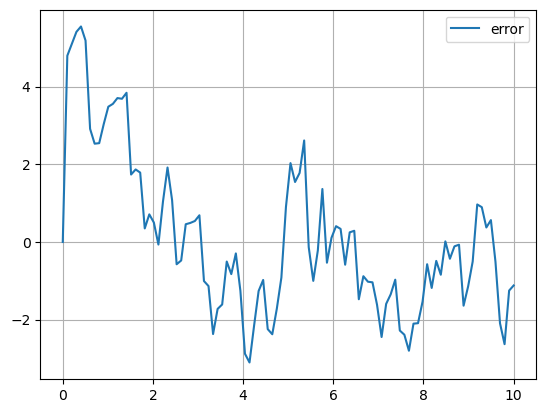

In [6]:
temperatures_opt, kalman_gains = kalman_filter_1d(measured, sigma_model, sigma_sensor)

sns.lineplot(x=t, y=temperatures, label='model')
sns.lineplot(x=t, y=measured, label='measured')
sns.lineplot(x=t, y=temperatures_opt, label='kalman filter')
plt.grid(True)

# plot errors with true state
plt.figure()
sns.lineplot(x=t, y=temperatures - temperatures_opt, label='error')
plt.grid(True)

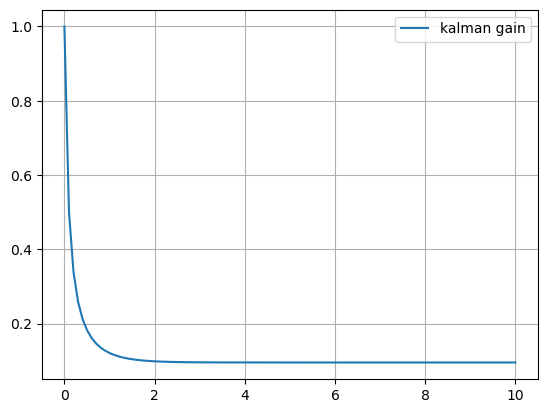

In [7]:
# plot kalman gain
plt.figure()
sns.lineplot(x=t, y=kalman_gains, label='kalman gain')
plt.grid(True)

### Now we try with different values $x_0$ and $e_0$ to prove that it will still converge

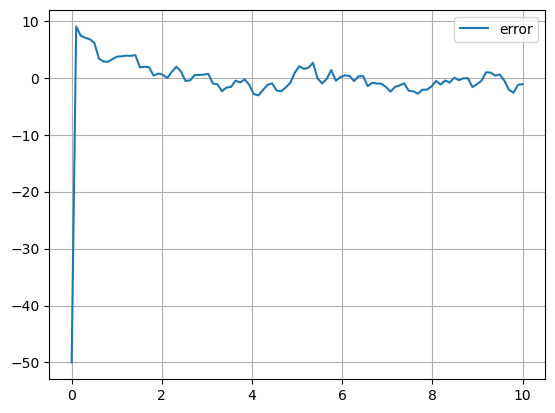

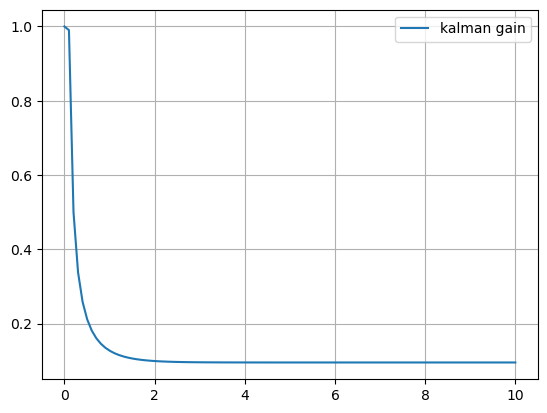

In [8]:
temp1, gains1 = kalman_filter_1d(measured, sigma_model, sigma_sensor, x0_opt=150, e0_opt=100)

plt.figure()
sns.lineplot(x=t, y=temperatures - temp1, label='error')
plt.grid(True)

plt.figure()
sns.lineplot(x=t, y=gains1, label='kalman gain')
plt.grid(True)

### Try with low $e_0$ to slow down convergence

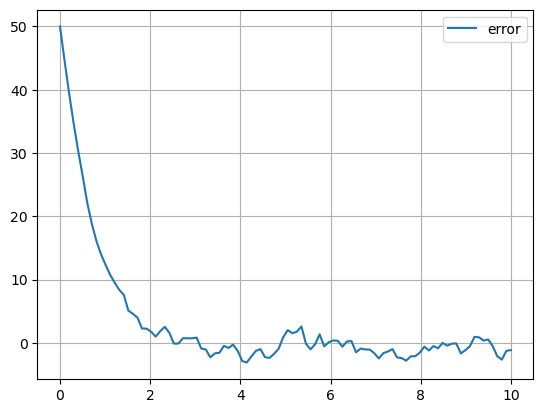

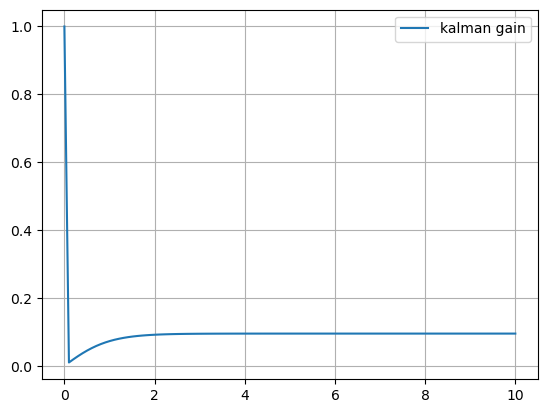

In [9]:
temp1, gains1 = kalman_filter_1d(measured, sigma_model, sigma_sensor, x0_opt=50, e0_opt=0.1)

plt.figure()
sns.lineplot(x=t, y=temperatures - temp1, label='error')
plt.grid(True)

plt.figure()
sns.lineplot(x=t, y=gains1, label='kalman gain')
plt.grid(True)

# Task 2

- Record data from linear accelerometer and GPS tracker
- Apply Kalman filter to predict traveled distance
- Compare distances from GPS and Kalman filter

I searched for alternative solutions and leave some references to them here:

1. [Pretty similar problem of GPS and linear accelerometer data fusion](https://www.pyrunner.com/weblog/2018/04/12/kalman-example/)
1. [General ideas on Kalman Filter](https://www.kalmanfilter.net/default.aspx)
1. [Kalman filter for multidimensional case](https://web.archive.org/web/20181016052255/https://www.cl.cam.ac.uk/~rmf25/papers/Understanding%20the%20Basis%20of%20the%20Kalman%20Filter.pdf)

In [10]:
!pip3 install numpy pandas matplotlib seaborn scipy utm folium

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable


In [11]:
# read pandas dataframe from csv file
df = pd.read_csv('runs/run2.csv', sep=',')

# leave only the columns we need
df = df[['time', 'ax', 'ay', 'az', 'Latitude', 'Longitude', 'Speed (m/s)']]

# remove first row
df = df.iloc[1:]

df.head()

,time,ax,ay,az,Latitude,Longitude,Speed (m/s)
1,0.041157,0.0,0.0,0.0,55.750205,48.741028,0.0
2,0.060747,0.0,0.0,0.0,55.750205,48.741028,0.0
3,0.061258,0.0,0.0,0.0,55.750205,48.741028,0.0
4,0.081102,0.0,0.0,0.0,55.750205,48.741028,0.0
5,0.081461,0.0,0.0,0.0,55.750205,48.741028,0.0


### We can visualize the map actually to see where we are

In [25]:
import folium

m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=25)

trail = folium.PolyLine(
    locations=df[['Latitude', 'Longitude']].values,
    weight=5,
    color='red'
).add_to(m)

m

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

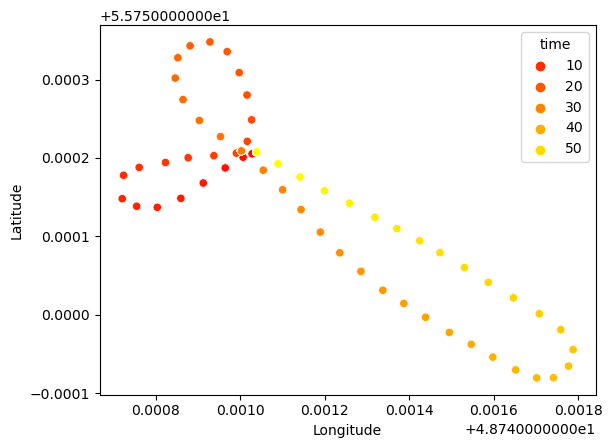

In [13]:
sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='time', palette='autumn')

### GPS has to be converted to meters

In [14]:
# convert gps coordinates to utm
import utm

def gps_to_utm(lat, lon):
    return utm.from_latlon(lat, lon)

# convert gps coordinates to utm
u = [gps_to_utm(lat, lon)[:2] for lat, lon in zip(df['Latitude'], df['Longitude'])]

df['x'], df['y'] = zip(*u)

In [15]:
# R is uncertainty with noise of measurements
# calculate from standard deviation of measurements

std_x = df['x'].std()
std_y = df['y'].std()

R = np.diag([std_x**2, std_y**2])

R

array([[375.96699265,   0.        ],
       [  0.        , 181.91831341]])

In [26]:
# Q is uncertainty with noise of model
# calculate from standard deviation of model
# idea of calculating Q was taken from here https://www.pyrunner.com/weblog/2018/04/12/kalman-example/
# it works :)

std_ax = df['ax'].std()
std_ay = df['ay'].std()


Q1 = lambda dt: np.array([[(dt**3)/6, (dt**2)/2, dt, 0, 0, 0]]).T
Q2 = lambda dt: np.array([[0, 0, 0, (dt**3)/6, (dt**2)/2, dt]]).T

Q = lambda dt: (Q1(dt) @ Q1(dt).T * std_ax ** 2 + Q2(dt) @ Q2(dt).T) * std_ay ** 2


In [17]:
# define measurements vectors, state to measurements matrix, state matrix

z = np.array(df[['x', 'y']].values)

F = lambda dt: np.array([
    [1, dt, dt**2/ 2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, dt**2/ 2],
    [0, 0, 0, 0, 1, dt],
    [0, 0, 0, 0, 0, 1],
])

H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
])

In [18]:
# actual kalman filter implementation

x_t_prevt = []
x_t_t = []
P_t_prevt = []
P_t_t = []
K_t = []

times = np.array(df['time'].values)
dts = np.gradient(times)    # dt between steps differs

x0 = np.array([df['x'].values[0], 0, 0, df['y'].values[0], 0, 0])

for i in range(len(z)):
    # dt = dts[i]
    dt = dts.mean()
    x_t_prevt.append(x_t_t[i-1] if i > 0 else x0)
    P_t_prevt.append(P_t_t[i-1] if i > 0 else np.eye(6))
    x_t_t.append(F(dt) @ x_t_prevt[i])
    P_t_t.append(F(dt) @ P_t_prevt[i] @ F(dt).T + Q(dt))
    K_t.append(P_t_t[i] @ H.T @ np.linalg.inv(H @ P_t_t[i] @ H.T + R))
    
    x_t_t[i] = x_t_t[i] + K_t[i] @ (z[i] - H @ x_t_t[i])
    
    P_t_t[i] = (np.eye(6) - K_t[i] @ H) @ P_t_t[i]

x_t_t = np.array(x_t_t)
P_t_t = np.array(P_t_t)
K_t = np.array(K_t)


Text(0, 0.5, 'y, (m)')

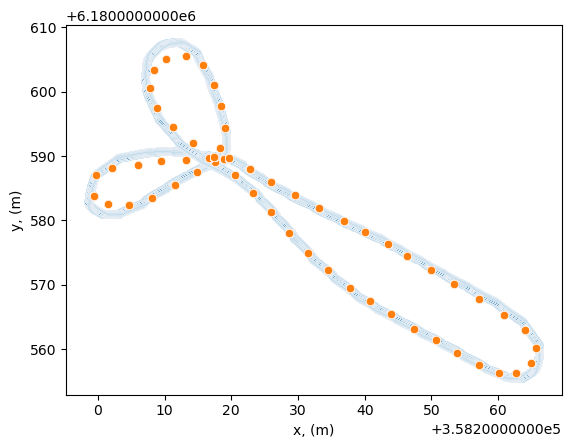

In [19]:
sns.scatterplot(x=x_t_t[:, 0], y=x_t_t[:, 3])
sns.scatterplot(x=z[:, 0], y=z[:, 1])
plt.xlabel('x, (m)')
plt.ylabel('y, (m)')

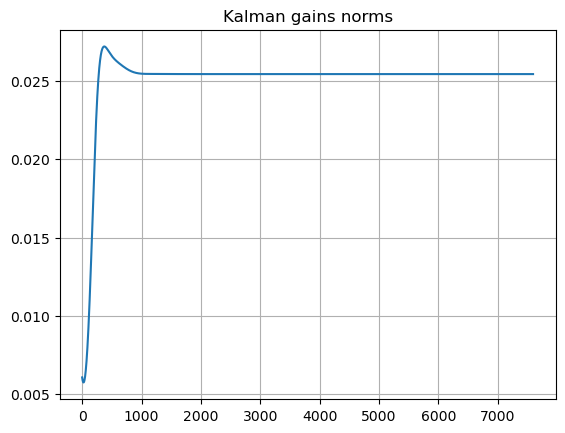

In [20]:
# plot gains norms
plt.title('Kalman gains norms')
plt.plot(np.linalg.norm(K_t, axis=(1, 2)))
plt.grid(True)

In [21]:
# find distance between each point and the previous point
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# calculate distance between each point and the previous point
distances = np.zeros(x_t_t.shape[0])
for i in range(1, x_t_t.shape[0]):
    p1 = np.array([x_t_t[i][0], x_t_t[i][3]])
    p2 = np.array([x_t_t[i-1][0], x_t_t[i-1][3]])

    distances[i] = distances[i - 1] + np.linalg.norm(p1 - p2)

distances[-1], "distance in meters through kalman filter"

(214.29086172746875, 'distance in meters through kalman filter')

In [22]:
# calculate distance between each point and the previous point
distances_gps = np.zeros(z.shape[0])
for i in range(1, z.shape[0]):
    p1 = np.array([z[i][0], z[i][1]])
    p2 = np.array([z[i-1][0], z[i-1][1]])

    distances_gps[i] = distances_gps[i-1] + np.linalg.norm(p1 - p2)

distances_gps[-1], "distance in meters through gps only"

(201.96240874960955, 'distance in meters through gps only')

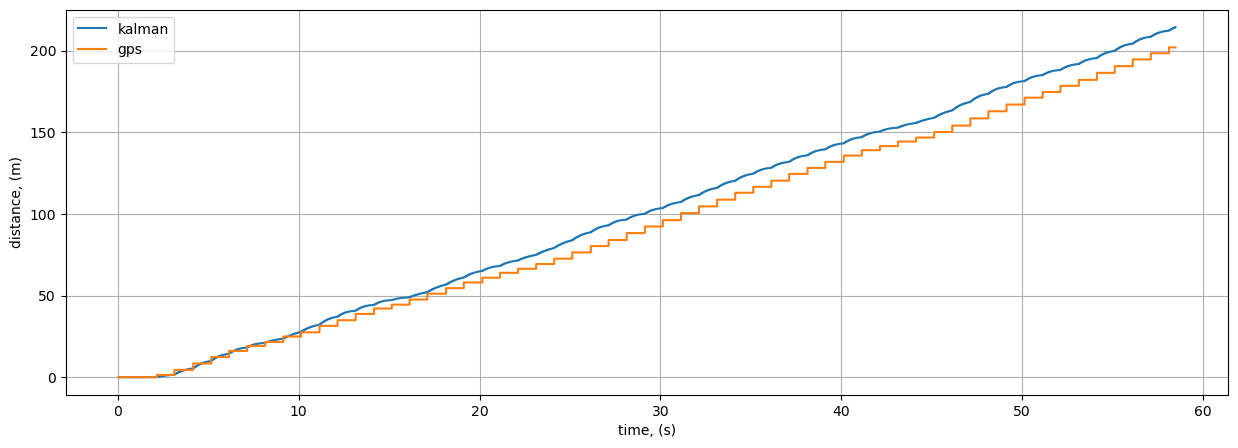

In [23]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=times, y=distances, label='kalman')
sns.lineplot(x=times, y=distances_gps, label='gps')
plt.xlabel('time, (s)')
plt.ylabel('distance, (m)')
plt.grid()

- If we use maps and rulers we can see that the distance from kalman filter is pretty much close to real one
- GPS distance is stepped due precision and we "fill" these gaps using accelerometer data